In [9]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [10]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

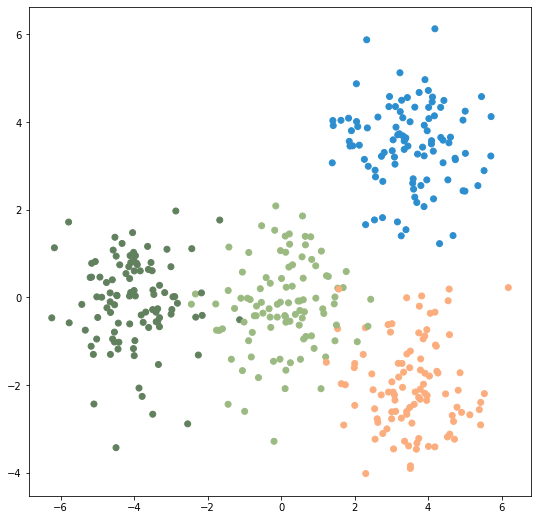

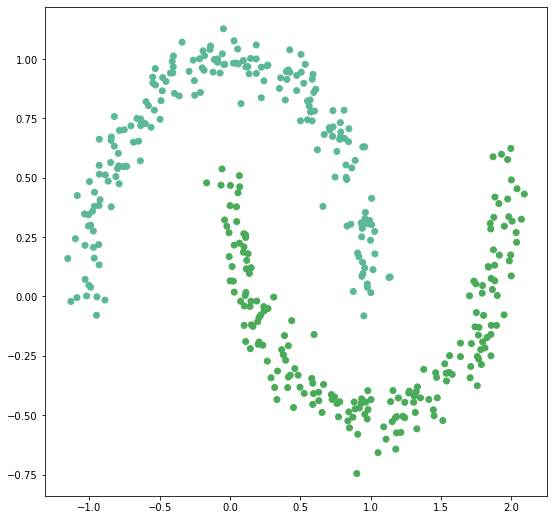

In [11]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

# KMeans

In [12]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", max_iter: int = 300):        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        
    
    def fit(self, X: np.array, y = None) -> NoReturn:
        self.X = X.copy()
        self.y = y
        self.all_elems = X.shape[0]
        self.features = X.shape[1]
        self.centroids = self.initialize() # координаты центров
        
        # пересчет центроидов
        for i in range(self.max_iter):
            labels = self.voronoi(X) # каждой точке присваивает лейбл
            
            new_centroids = np.array([[0 for i in range(self.features)] for j in range(self.n_clusters)])
            
            # в каждом лейбле:
            for i in range(self.n_clusters):
                cluster_elems = X[labels == i] # все х в данном кластере   
                # проверка на пустоту
                if cluster_elems.shape[0] == 0:
                    new_centroids[i] = self.initialize(reinit=True)[0]
                else:    
                    new_centroids[i] = np.mean(cluster_elems, axis=0)    
            self.centroids = new_centroids
            
    
    # инициализация центроидов
    def initialize(self, reinit=False): 
        count = self.n_clusters if reinit == False else 1
        
        if self.init == "random":
            # вернуть n_clusters случайных точек на плоскости 
            centroids = np.array([[0 for i in range(self.features)] for j in range(count)])
            for i in range(self.features):
                x_min = np.min(self.X[:,i])
                x_max = np.max(self.X[:,i])
                centroids[:,i] = np.random.uniform(x_min, x_max, count)
        
        elif self.init == "sample":
            # вернуть n_clusters точек из выборки
            centroids = self.X[np.random.choice(self.all_elems, count, replace=None)]
        
        elif self.init == "k-means++":            
            centroids = np.array([[0 for i in range(self.features)] for j in range(count)])
            centroids[0] = self.X[np.random.choice(self.all_elems)]
            if reinit:
                return centroids
            
            M = np.array([np.inf for i in range(self.all_elems)])
            for i in range(1, count):
                M_new = np.linalg.norm(self.X - centroids[i - 1], axis=1)
                M = np.min((M, M_new), axis=0)
                M_2 = M ** 2 / np.sum(M ** 2)
                centroids[i] = self.X[np.random.choice(self.all_elems, size=1, p=M_2)]

        else:
            raise ValueError("Unknown method")
            
        return centroids
    
    
    # разбиение пространства на кластеры     
    def voronoi(self, X):
        labels = np.array([-1 for i in range(X.shape[0])])        
        for i, x in enumerate(X):
            labels[i] = np.argmin(np.linalg.norm(self.centroids - x, axis=1))
        return labels
    
                    
    def predict(self, X: np.array) -> np.array:
        labels = self.voronoi(X)
        return labels


# Test

1. RANDOM

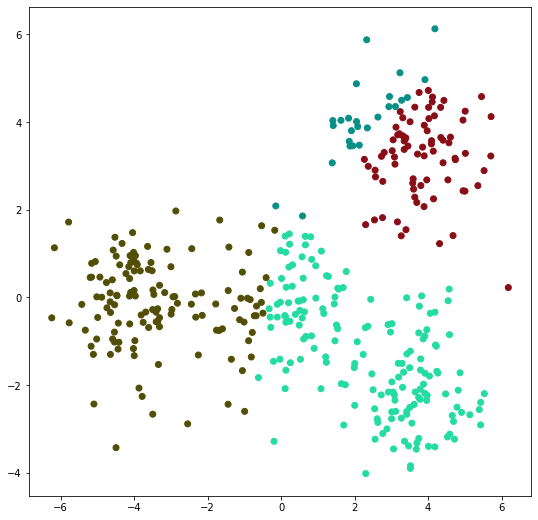

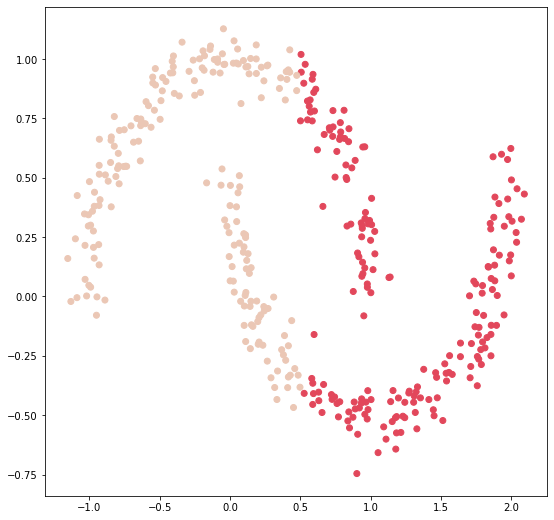

In [13]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

2. SAMPLE

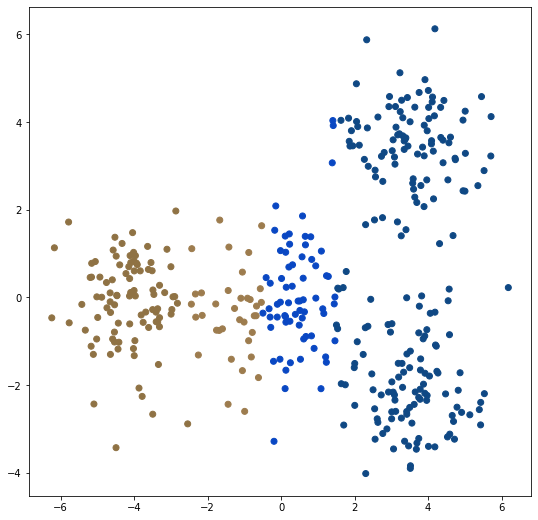

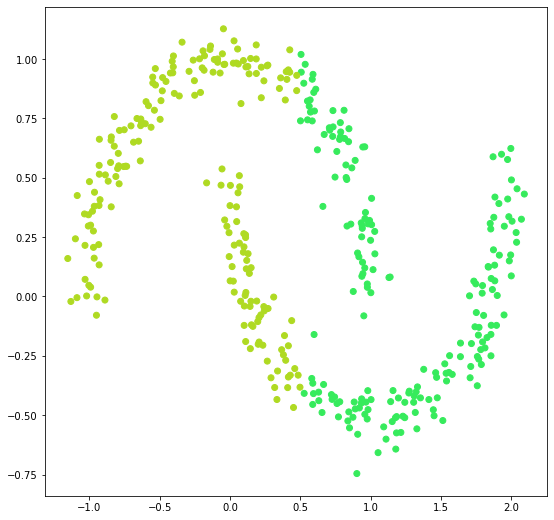

In [14]:
kmeans = KMeans(n_clusters=4, init="sample")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

3. K-MEANS++

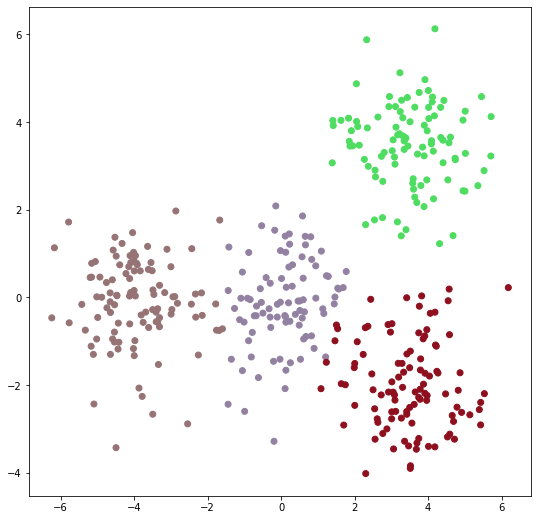

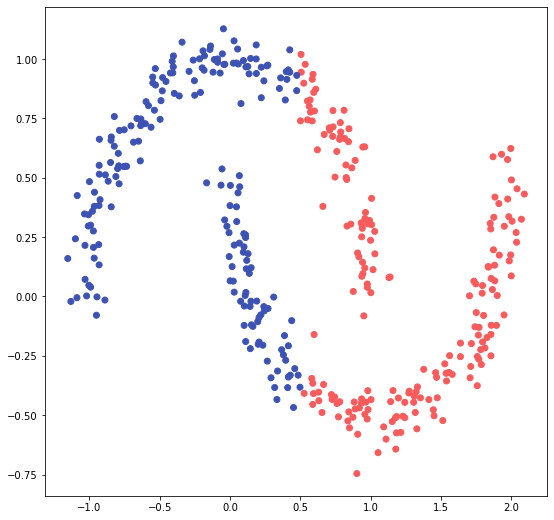

In [15]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

# DBScan

In [16]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        self.Tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        
        neighbours = self.Tree.query_radius(X, r=self.eps) # запрос соседей в радиусе
        all_clusters = np.full(X.shape[0], -1) 
        curr_cluster = 0
        
        for point in range(X.shape[0]):
            
            # если присвоен кластер или мало соседей - проспустить
            if all_clusters[point] != -1 or neighbours[point].shape[0] < self.min_samples:
                continue
  
            Q = deque()
            Q.append(point)
            all_clusters[point] = curr_cluster
            
            while Q:
                point_2 = Q.pop() 
                for neighbour_i in neighbours[point_2]:
                    if all_clusters[neighbour_i] == -1:
                        all_clusters[neighbour_i] = curr_cluster
                        if neighbours[neighbour_i].shape[0] >= self.min_samples:
                            Q.append(neighbour_i)
                            
            curr_cluster += 1
            
        # кластер для выбросов
        if -1 in all_clusters:
            extra_cluster = len(np.unique(all_clusters)) - 1
            all_clusters = np.where(all_clusters == -1, extra_cluster, all_clusters)
        
        return all_clusters

# Test

1. Euclidean

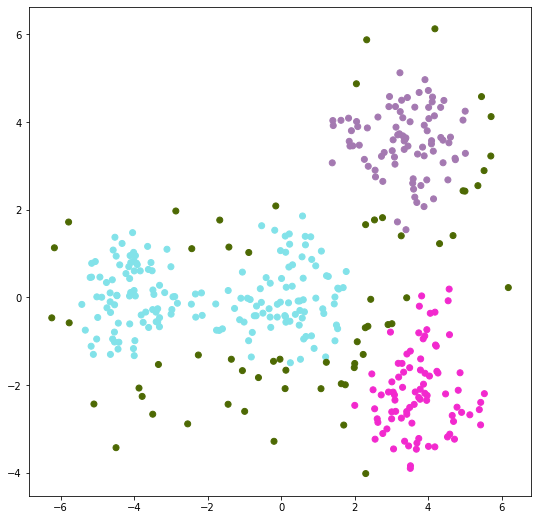

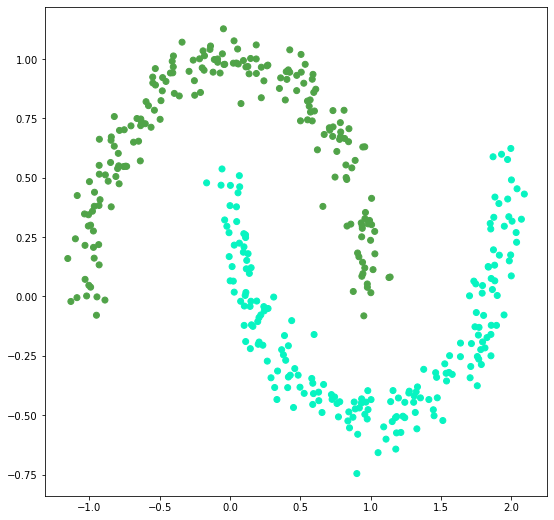

In [17]:
dbscan = DBScan(eps=0.7, min_samples=10, metric="euclidean")
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=5, metric="euclidean")
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

2. Manhattan

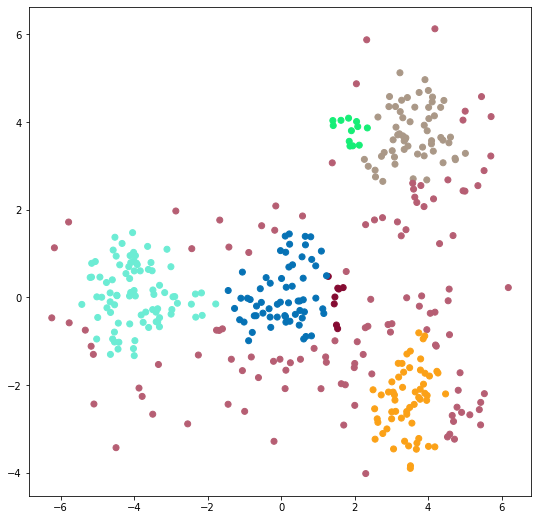

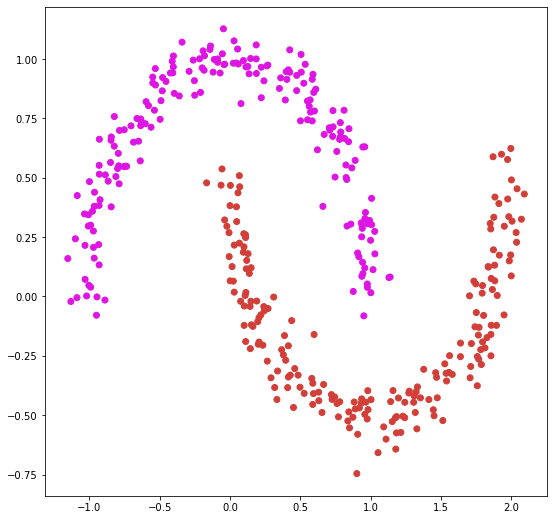

In [18]:
dbscan = DBScan(eps=0.7, min_samples=10, metric="manhattan")
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.3, min_samples=5, metric="manhattan")
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

3. Chebyshev

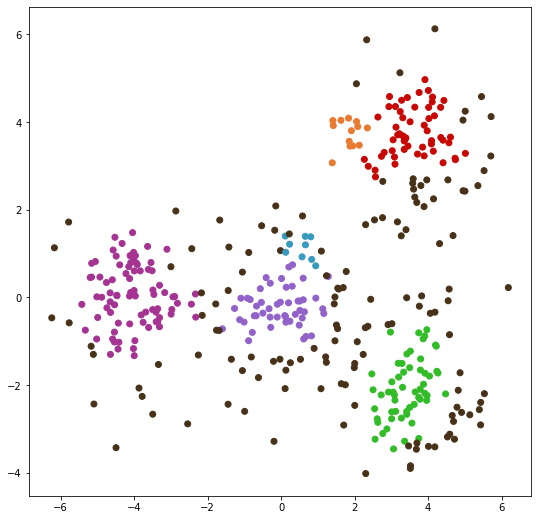

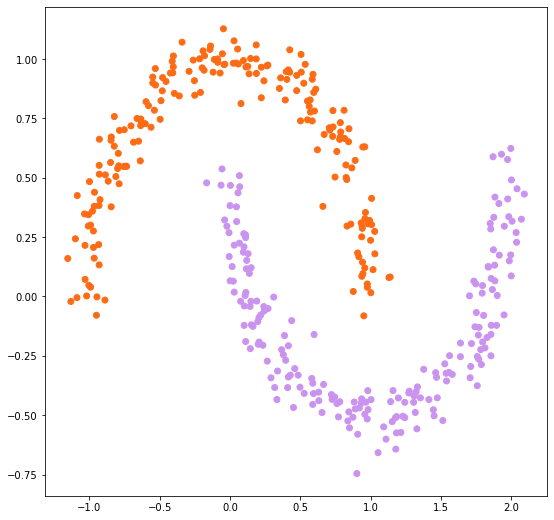

In [19]:
dbscan = DBScan(eps=0.5, min_samples=11, metric="chebyshev")
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=5, metric="chebyshev")
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

# AgglomertiveClustering

In [20]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
        
        
    def func_linkage(self, new_distances):
        if self.linkage == "average":
            return new_distances.mean()
        
        elif self.linkage == "single":
            return new_distances.min()
        
        elif self.linkage == "complete":
            return new_distances.max()
        
        else:
            raise ValueError('Unknown method')
        
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        n = X.shape[0]
        
        # расстояние между всеми парамами
        all_distances = np.zeros((n, n))               
        for i, point in enumerate(X): 
            all_distances[:,i] = all_distances[i,:] = np.linalg.norm(X - point, axis=1)
            all_distances[i,i] = np.inf            
                
        # итерации
        clusters = [[i] for i in range(n)]
        for iteration in range(n - self.n_clusters):
            indices = [0, 1]
            distance = np.inf
            for i in range(len(clusters) - 1):
                for j in range(i + 1, len(clusters)):
                    new_distances = np.array([all_distances[m, clusters[j]] for m in clusters[i]])
                    distance_btwn_cls = self.func_linkage(new_distances)                    
                    if distance_btwn_cls < distance:
                        distance = distance_btwn_cls
                        indices = [i, j]
                        
            i, j = indices
            clusters[i] += clusters[j]
            clusters[j], clusters[-1] = clusters[-1], clusters[j]      
            clusters.pop()
        
        #лейблы
        labels = np.array([0 for i in range(n)])
        for i, points in enumerate(clusters):
            for j in points:
                labels[j] = i
                
        return labels

# Test

1. Average

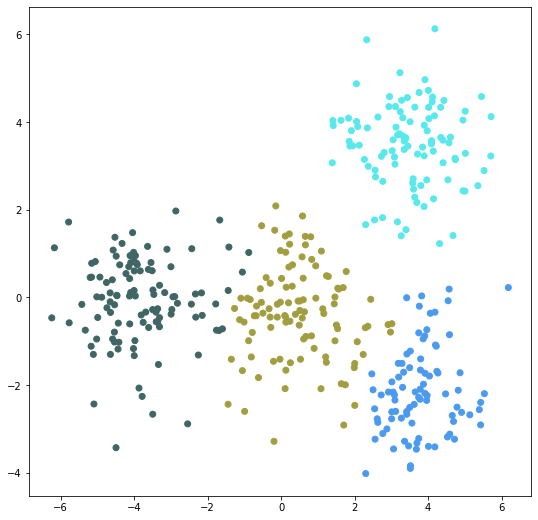

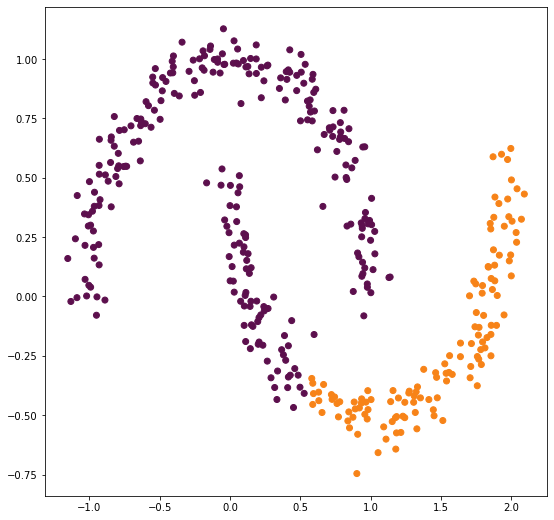

Wall time: 7min 1s


In [21]:
%%time
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="average")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

2. Single

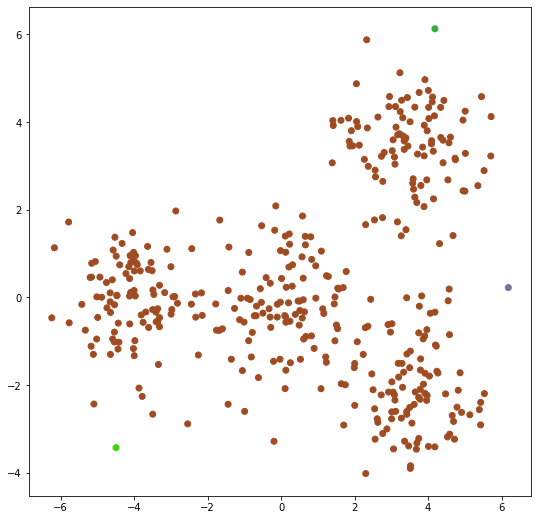

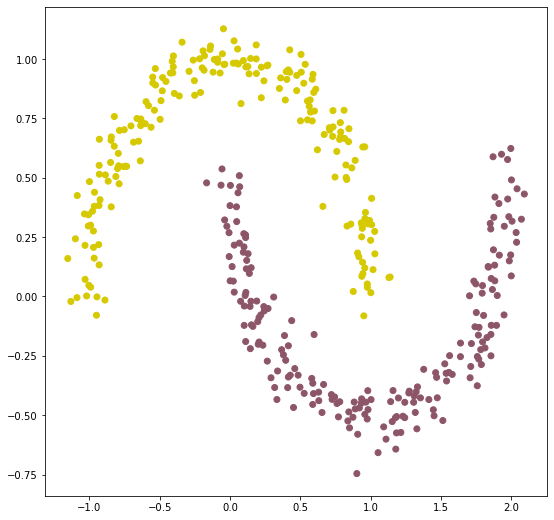

Wall time: 6min 8s


In [22]:
%%time
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="single")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

3. Complete

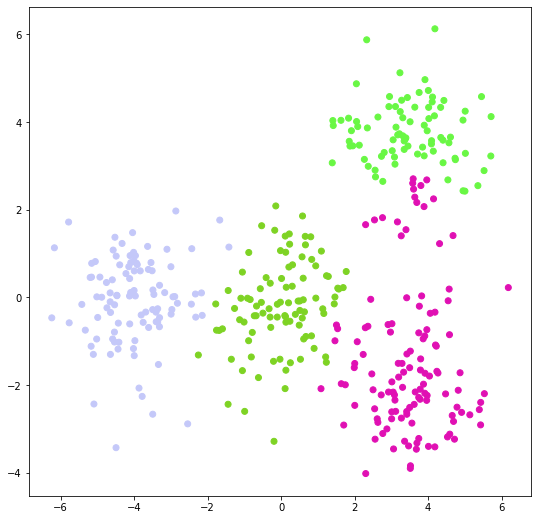

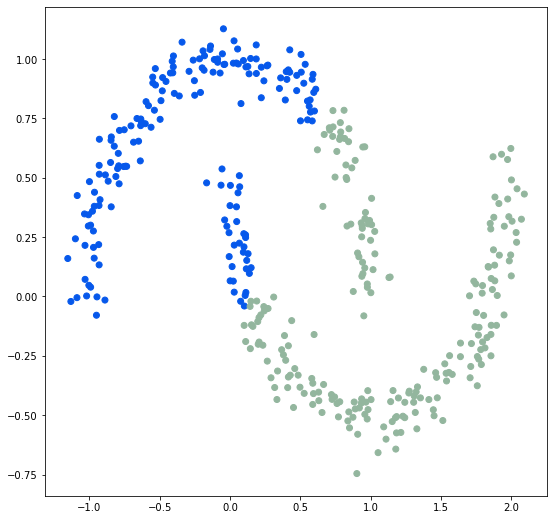

Wall time: 5min 13s


In [23]:
%%time
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="complete")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)